# GSEA with gseapy

In [1]:
#Boilerplate Import 
import sys
sys.path.append('..')
import os
from itertools import chain
from collections import defaultdict
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scripts import utils
from scripts.analysis import build_loci

In [2]:
BASE = '../data'

unenr_grouped_loci = utils.load(os.path.join(BASE,"unenriched_grouped_loci.pkl.gz"))
enr_grouped_loci = utils.load(os.path.join(BASE,"enriched_grouped_loci.pkl.gz"))
grouped_loci = utils.load(os.path.join(BASE,"grouped_loci.pkl.gz"))

In [3]:
import gseapy as gp
import goatools

obodag = goatools.obo_parser.GODag('go-basic.obo')

load obo file go-basic.obo
go-basic.obo: fmt(1.2) rel(2016-07-16) 46,953 GO Terms


In [4]:
def make_ranked_df(grouped_loci):
    df = build_loci.get_sig_df(grouped_loci)
    
    # set insiginifcant loci to the center rank of the gene list
    df['logfc'] = df.where((abs(df['logfc']) <= 2) | (df['p_value'] <= 0.05))['logfc'].replace(np.nan, 0)
    
    # Right now FC ratios are light/heavy
    # light == Tcell and heavy == RAG
    # GSEA goes from low to High, so negative logFC values will come first
    # This will give genes high in RAG highest priority
    # Switching the sign with put the genes highest in Tcell mice up first
    df['logfc'] = -1 * df['logfc']
    
    # filter out the mouse and human genes
    mh_loci = build_loci.get_annotation_df(grouped_loci).query('mouse_human').index.tolist()
    df = df.query('~(id in {})'.format(mh_loci))

    
    # prep the ranking dataframe to gesapy specs.
    rank_df = df[['id', 'logfc']].rename(columns={'id': 'gene_name', 'logfc': 'rank'})
    
    return rank_df.sort_values('rank').reset_index(drop=True)


In [5]:
def make_go2Gene_map(grouped_loci, ontology='MF'):
    ontology_map = {'MF': 'molecular_function', 'BP': 'biological_process', 'CC': 'cellular_component'}
    
    out = defaultdict(list)    
    for l in grouped_loci:
        if 'go' in l.annotations:
            for go in l.annotations['go']:
                if obodag[go].namespace == ontology_map[ontology]:
                    out[go].append(l.cluster_id)
                    for parent in obodag[go].get_all_parents():
                        if obodag[parent].namespace == ontology_map[ontology]:
                            out[parent].append(l.cluster_id)
                
    return out

In [6]:
def filter_go2gene_map(go_locus):
    
    # Remove "very broad" gene sets. Arbitrary definition: gene sets that emcompass >50% of all IDs
    all_ids = set(chain(*go_locus.values()))
    go_locus = {key: value for (key, value) in go_locus.items() if len(value) / len(all_ids) <= 0.5}

    # Remove terms with less than 5 members: changed from 10 to 5 becasue small #s of proteins compared
    # to what you would find wiht genes
    go_locus = {key: value for (key, value) in go_locus.items() if len(value) >= 5}

    # Remove child terms with identical gene sets as their parents
    to_remove = set()
    for parent in go_locus.keys():
        # If child term has exact same members as parent, remove
        child_ids = [x.id for x in obodag[parent].children if x.id in go_locus.keys()]
        for child in child_ids:
            if go_locus[child] == go_locus[parent]:
                to_remove.add(child)
    go_locus = {key: value for (key, value) in go_locus.items() if key not in to_remove}

    # Remove sibling terms with identical gene sets
    to_remove = set()
    for brother in go_locus.keys():
        for parent in obodag[brother].parents:
            siblings = set([y.id for y in parent.children])
            siblings.remove(brother)
            for sibling in siblings:
                if sibling in go_locus.keys() and go_locus[brother] == go_locus[sibling]:
                    to_remove.add(sibling)
    go_locus = {key: value for (key, value) in go_locus.items() if key not in to_remove}

    return go_locus

In [7]:
def gomap_to_csv(go2gene, out_file = 'test.tsv'):

    out = ""
    for term, loci in go2gene.items():
        out += "{}\t".format(term)
        out += "{}\t".format(obodag[term].name)
        out += '\t'.join(list(map(str,loci)))
        out += '\n'
        
    with open(out_file, 'w') as fout:
        fout.write(out)

In [8]:
def run_go_gsea(rank_df, g2g_map):
    """
    A ranked df and go2gene mapping returns the result dataframe for GSEA against all go-Terms
    
    loci must be grouped such that avg_ratio and p-values are correct for 1 phenotype
    see rt_unenr_grouped_loci above for example
    """
    import gseapy as gp
        
    # save the go 2 gene map, since gseapy doesn't seem to be able to use one already in memory
    gomap_to_csv(g2g_map, 'temp.gmt')
    
    res = gp.prerank(rnk=rank_df, gene_sets='temp.gmt', outdir='tmp', min_size = 5, max_size=500, graph_num = len(g2g_map), savefigs=False)
      
    def get_go_name(term):
        return obodag[term].name
    
    res['name'] = res.index.map(get_go_name)
    
    return res.sort_values('nes', ascending=False)

In [9]:
def plot_gsea_result(row, rank):
    return gp.gsea_plot.gsea_plot(rank, row['name'], row.hit_index, row.nes, row.pval, row.fdr, row.rank_ES, phenoPos= 'Tcell', phenoNeg='RAG')

In [10]:
go2gene = make_go2Gene_map(grouped_loci)

In [11]:
len(go2gene)

613

In [12]:
tst = gp.parser.gsea_rank_metric('unenriched_genes.rnk')

In [13]:
mf_map = make_go2Gene_map(grouped_loci)
mf_map_f = filter_go2gene_map(mf_map)

print('Unfiltered: {}\tFiltered: {}'.format(len(mf_map), len(mf_map_f)))

Unfiltered: 613	Filtered: 251


In [14]:
bp_map = make_go2Gene_map(grouped_loci, 'BP')
bp_map_f = filter_go2gene_map(bp_map)

print('Unfiltered: {}\tFiltered: {}'.format(len(bp_map), len(bp_map_f)))

Unfiltered: 725	Filtered: 266


In [15]:
unen_rank =  make_ranked_df(unenr_grouped_loci)

In [16]:
import warnings
warnings.filterwarnings('ignore')

mf_un_res = run_go_gsea(unen_rank, mf_map_f)
bp_un_res = run_go_gsea(unen_rank, bp_map_f)

161 gene_sets have been filtered out when max_size=500 and min_size=5
90 gene_sets used for further calculating
Start to compute enrichment socres...................... Thu Sep  8 16:20:51 2016
Start to compute esnulls................................ Thu Sep  8 16:20:51 2016
......This step might take a while to run. Be patient...
Start to compute pvals.................................. Thu Sep  8 16:21:04 2016
start to compute fdrs................................... Thu Sep  8 16:21:04 2016
Statistial testing finished............................. Thu Sep  8 16:21:04 2016
Start to generate gseapy reports, and produce figures... Thu Sep  8 16:21:04 2016
Congratulations. GSEAPY run successfully................
The Job is done.................................Goodbye! Thu Sep  8 16:21:05 2016
138 gene_sets have been filtered out when max_size=500 and min_size=5
128 gene_sets used for further calculating
Start to compute enrichment socres...................... Thu Sep  8 16:21:06 2016
Start

In [17]:
mf_un_TC = mf_un_res.query('nes > 0 and pval < 0.05').sort_values('nes', ascending=False)
mf_un_RAG = mf_un_res.query('nes < 0 and pval < 0.05').sort_values('nes', ascending=True)

bp_un_TC = bp_un_res.query('nes > 0 and pval < 0.05').sort_values('nes', ascending=False)
bp_un_RAG = bp_un_res.query('nes < 0 and pval < 0.05').sort_values('nes', ascending=True)

### Molecular Function - Up in Tcell

In [18]:
res_cols = ['name', 'es', 'nes', 'pval', 'fdr', 'gene_set_size', 'matched_size']

In [19]:
mf_un_TC[res_cols]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Enrich_terms,,,,,,,
GO:0016853,isomerase activity,0.799632,2.915518,0.000000,0.002000,271,90
GO:0016860,intramolecular oxidoreductase activity,0.749289,1.967516,0.013468,0.073328,93,16
GO:0016614,"oxidoreductase activity, acting on CH-OH group...",0.540728,1.701296,0.011594,0.227022,140,33
GO:0016620,"oxidoreductase activity, acting on the aldehyd...",0.487019,1.646839,0.007692,0.254110,185,37
GO:0016829,lyase activity,0.351135,1.434276,0.045273,0.291610,425,129


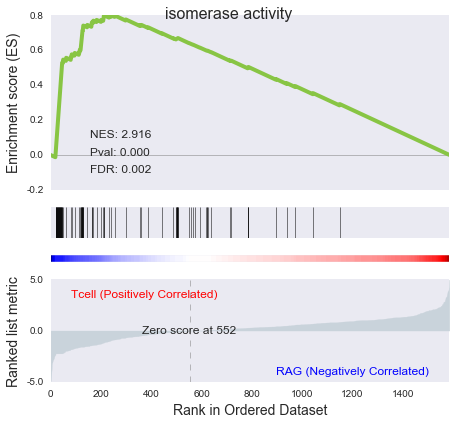

In [20]:
sns.set_style('dark')
plot_gsea_result(mf_un_TC.iloc[0], unen_rank)

### Biological Process - Up in Tcell

In [21]:
bp_un_TC[res_cols]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Enrich_terms,,,,,,,
GO:0006733,oxidoreduction coenzyme metabolic process,0.609703,2.480818,0.000000,0.022006,252,132
GO:0072524,pyridine-containing compound metabolic process,0.609703,2.420546,0.000000,0.016767,252,132
GO:0044712,single-organism catabolic process,0.599509,2.397951,0.000000,0.018164,299,147
GO:0016052,carbohydrate catabolic process,0.610162,2.394705,0.000000,0.018164,264,138
GO:0009056,catabolic process,0.569204,2.361925,0.000000,0.020609,341,163
GO:1901657,glycosyl compound metabolic process,0.539649,2.217859,0.000000,0.038773,346,150
GO:0006753,nucleoside phosphate metabolic process,0.538258,2.216663,0.000000,0.039122,393,158
GO:0044724,single-organism carbohydrate catabolic process,0.610162,2.188759,0.000000,0.045060,262,138
GO:1901135,carbohydrate derivative metabolic process,0.541522,2.178202,0.000000,0.034581,439,158


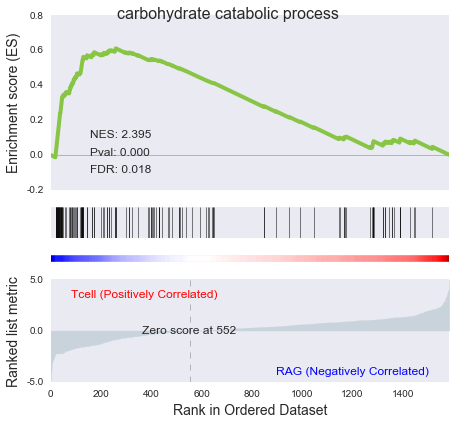

In [22]:
plot_gsea_result(bp_un_res.loc['GO:0016052'], unen_rank)

### Molecular Function - Up in RAG

In [23]:
mf_un_RAG[res_cols]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Enrich_terms,,,,,,,
GO:0034062,RNA polymerase activity,-0.547794,-2.487378,0.000000,0.000000,142,82
GO:0016779,nucleotidyltransferase activity,-0.488109,-2.344869,0.000000,0.000000,255,119
GO:0016781,"phosphotransferase activity, paired acceptors",-0.453596,-2.260370,0.000000,0.000000,199,73
GO:0003677,DNA binding,-0.462263,-2.079790,0.000000,0.000000,147,85
GO:0022804,active transmembrane transporter activity,-0.648388,-1.904558,0.000000,0.000711,138,34
GO:0022892,substrate-specific transporter activity,-0.710105,-1.900059,0.000000,0.000741,82,16
GO:0022891,substrate-specific transmembrane transporter a...,-0.710105,-1.895998,0.000000,0.000762,80,16
GO:0022857,transmembrane transporter activity,-0.648388,-1.887978,0.000000,0.000667,152,34
GO:0016765,"transferase activity, transferring alkyl or ar...",-0.611631,-1.884995,0.000000,0.000593,84,31


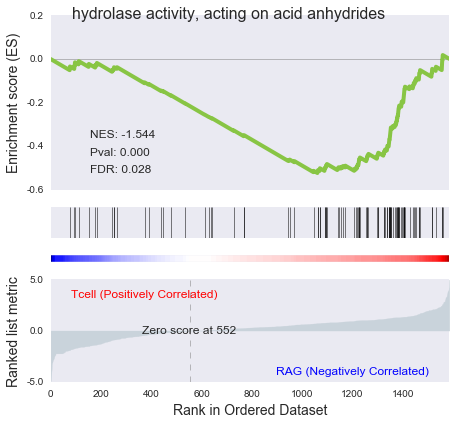

In [24]:
plot_gsea_result(mf_un_res.loc['GO:0016817'], unen_rank)

### Biological Process - Up in RAG

In [25]:
bp_un_RAG[res_cols]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Enrich_terms,,,,,,,
GO:0032774,RNA biosynthetic process,-0.547794,-2.444051,0.000000,0.000000,144,82
GO:0016070,RNA metabolic process,-0.496608,-2.320946,0.000000,0.000000,307,100
GO:0097659,nucleic acid-templated transcription,-0.547794,-2.319261,0.000000,0.000000,142,82
GO:0090304,nucleic acid metabolic process,-0.497782,-2.303856,0.000000,0.000000,318,101
GO:0034654,nucleobase-containing compound biosynthetic pr...,-0.476661,-2.142337,0.000000,0.000000,242,96
GO:0018130,heterocycle biosynthetic process,-0.467044,-2.140437,0.000000,0.000000,278,105
GO:0019438,aromatic compound biosynthetic process,-0.473302,-2.139006,0.000000,0.000000,272,103
GO:1901362,organic cyclic compound biosynthetic process,-0.467044,-2.113296,0.000000,0.000000,279,105
GO:0034637,cellular carbohydrate biosynthetic process,-0.602021,-1.976555,0.000000,0.000000,52,28


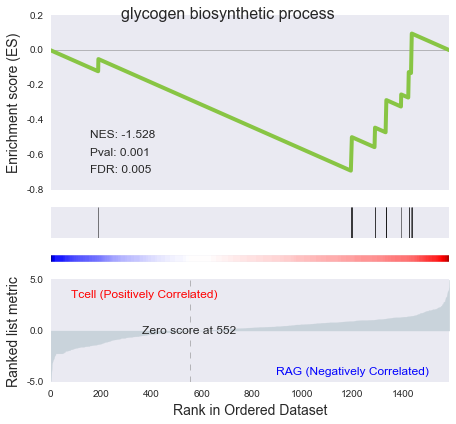

In [26]:
plot_gsea_result(bp_un_res.loc['GO:0005978'], unen_rank)

## GSEA on BioGlyCMK Enriched Samples

In [27]:
enr_rank =  make_ranked_df(enr_grouped_loci)

In [28]:
# [l for l in enr_grouped_loci if l.cluster_id in enr_rank['gene_name'].tolist()]
enr_mf_map = make_go2Gene_map(grouped_loci)
enr_mf_map_f = filter_go2gene_map(enr_mf_map)
print('MF Unfiltered: {}\tFiltered: {}'.format(len(enr_mf_map), len(enr_mf_map_f)))

enr_bp_map = make_go2Gene_map(grouped_loci, 'BP')
enr_bp_map_f = filter_go2gene_map(enr_bp_map)
print('BP Unfiltered: {}\tFiltered: {}'.format(len(enr_bp_map), len(enr_bp_map_f)))

MF Unfiltered: 613	Filtered: 251
BP Unfiltered: 725	Filtered: 266


In [29]:
import random
random.seed(2222)
mf_enr_res = run_go_gsea(enr_rank, enr_mf_map_f)
bp_enr_res = run_go_gsea(enr_rank, enr_bp_map_f)

173 gene_sets have been filtered out when max_size=500 and min_size=5
78 gene_sets used for further calculating
Start to compute enrichment socres...................... Thu Sep  8 16:21:29 2016
Start to compute esnulls................................ Thu Sep  8 16:21:29 2016
......This step might take a while to run. Be patient...
Start to compute pvals.................................. Thu Sep  8 16:21:37 2016
start to compute fdrs................................... Thu Sep  8 16:21:37 2016
Statistial testing finished............................. Thu Sep  8 16:21:37 2016
Start to generate gseapy reports, and produce figures... Thu Sep  8 16:21:37 2016
Congratulations. GSEAPY run successfully................
The Job is done.................................Goodbye! Thu Sep  8 16:21:37 2016
159 gene_sets have been filtered out when max_size=500 and min_size=5
107 gene_sets used for further calculating
Start to compute enrichment socres...................... Thu Sep  8 16:21:38 2016
Start

In [30]:
mf_enr_TC = mf_enr_res.query('nes > 0 and pval < 0.05').sort_values('nes', ascending=False)
mf_enr_RAG = mf_enr_res.query('nes < 0 and pval < 0.05').sort_values('nes', ascending=True)

bp_enr_TC = bp_enr_res.query('nes > 0 and pval < 0.05').sort_values('nes', ascending=False)
bp_enr_RAG = bp_enr_res.query('nes < 0 and pval < 0.05').sort_values('nes', ascending=True)

### Up in T-Cell: Molecular Function

In [31]:
mf_enr_TC[res_cols]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Enrich_terms,,,,,,,
GO:0016741,"transferase activity, transferring one-carbon ...",0.897260,2.100605,0.000000,0.217608,48,9
GO:0016811,"hydrolase activity, acting on carbon-nitrogen ...",0.752923,2.088148,0.000000,0.114329,28,17
GO:0004175,endopeptidase activity,0.799833,2.085122,0.000000,0.077919,53,13
GO:0016810,"hydrolase activity, acting on carbon-nitrogen ...",0.717315,2.059230,0.000000,0.066302,69,24
GO:0008233,peptidase activity,0.678510,1.953485,0.000000,0.088743,141,23
GO:0005515,protein binding,0.620810,1.761102,0.012987,0.160231,143,20
GO:0016798,"hydrolase activity, acting on glycosyl bonds",0.592446,1.629223,0.014388,0.235216,71,18
GO:0004553,"hydrolase activity, hydrolyzing O-glycosyl com...",0.590114,1.612839,0.019737,0.218458,68,17
GO:0003676,nucleic acid binding,0.533491,1.585499,0.044492,0.217136,441,27


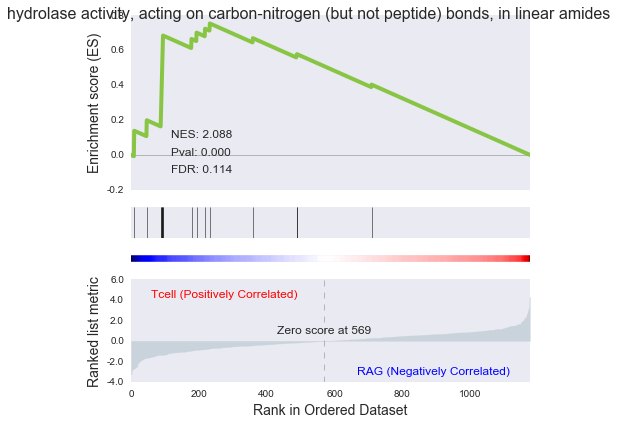

In [32]:
plot_gsea_result(mf_enr_res.loc['GO:0016811'], enr_rank)

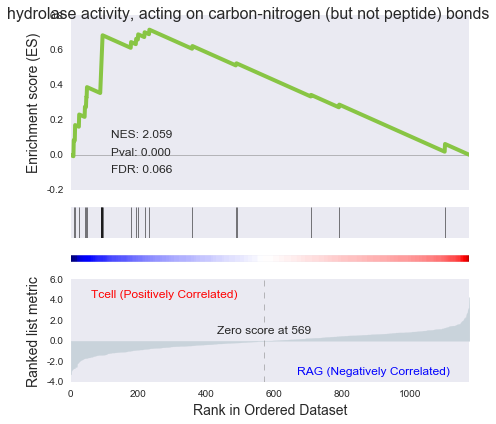

In [33]:
plot_gsea_result(mf_enr_res.loc['GO:0016810'], enr_rank)

### Up in T-Cell: Biological Process

In [34]:
bp_enr_TC[res_cols]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Enrich_terms,,,,,,,
GO:0044248,cellular catabolic process,0.742350,1.929647,0.000000,0.929241,70,13
GO:0034654,nucleobase-containing compound biosynthetic pr...,0.652523,1.869557,0.019305,0.583495,242,22
GO:0006508,proteolysis,0.668455,1.859585,0.000000,0.409715,104,23
GO:1901293,nucleoside phosphate biosynthetic process,0.691073,1.807689,0.012739,0.368666,97,14
GO:0009165,nucleotide biosynthetic process,0.691073,1.770358,0.000000,0.340929,94,14
GO:0090407,organophosphate biosynthetic process,0.674991,1.726242,0.017699,0.327099,115,15
GO:0044271,cellular nitrogen compound biosynthetic process,0.498229,1.679950,0.006369,0.336089,468,39
GO:0044282,small molecule catabolic process,0.709572,1.677899,0.030075,0.295826,40,11
GO:0018130,heterocycle biosynthetic process,0.509956,1.665879,0.016260,0.275561,278,35


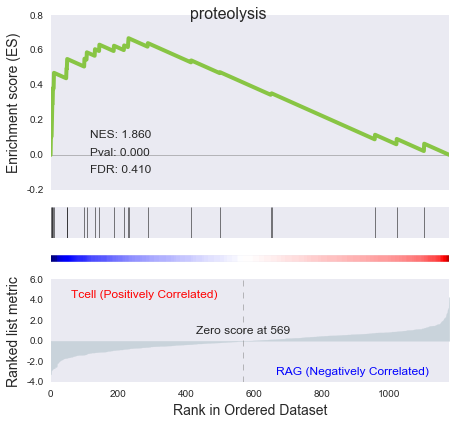

In [35]:
plot_gsea_result(bp_enr_res.loc['GO:0006508'], enr_rank)

### Up in RAG: Molecular Function

In [36]:
mf_enr_RAG[res_cols]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Enrich_terms,,,,,,,
GO:0016781,"phosphotransferase activity, paired acceptors",-0.731611,-2.481082,0.000000,0.000000,199,61
GO:0016301,kinase activity,-0.595516,-2.312345,0.000000,0.000000,304,72
GO:0051540,metal cluster binding,-0.561825,-2.093971,0.000000,0.000778,160,42
GO:0016887,ATPase activity,-0.532082,-1.928060,0.000000,0.002335,105,32
GO:0016820,"hydrolase activity, acting on acid anhydrides,...",-0.599631,-1.750391,0.010152,0.012611,119,15
GO:0022804,active transmembrane transporter activity,-0.599631,-1.720886,0.005348,0.014401,138,15
GO:0008184,glycogen phosphorylase activity,-0.697769,-1.709475,0.000000,0.014012,30,16
GO:0004645,phosphorylase activity,-0.705455,-1.677402,0.001258,0.017077,53,17
GO:0022857,transmembrane transporter activity,-0.599631,-1.674233,0.002625,0.016477,152,15


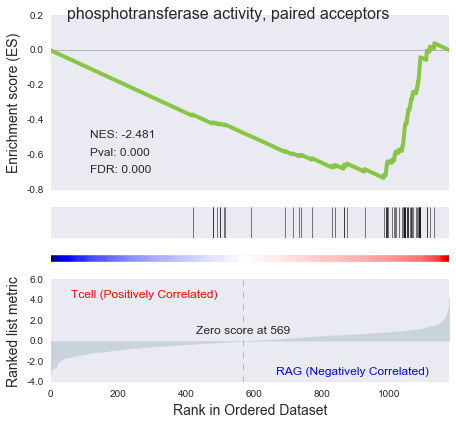

In [37]:
plot_gsea_result(mf_enr_res.loc['GO:0016781'], enr_rank)

### Up in RAG: Biological Process

In [38]:
bp_enr_RAG[res_cols]

,name,es,nes,pval,fdr,gene_set_size,matched_size
Enrich_terms,,,,,,,
GO:0022900,electron transport chain,-0.637462,-2.033277,0.000000,0.000607,66,17
GO:0030001,metal ion transport,-0.707442,-1.839925,0.001631,0.007285,34,15
GO:0015672,monovalent inorganic cation transport,-0.676945,-1.823407,0.001739,0.005059,161,16
GO:0006812,cation transport,-0.676945,-1.811505,0.000000,0.003794,172,16
GO:0006457,protein folding,-0.593953,-1.809858,0.000000,0.003035,84,20
GO:0006811,ion transport,-0.676945,-1.800801,0.000000,0.002934,176,16
GO:0006790,sulfur compound metabolic process,-0.625252,-1.743428,0.004598,0.004596,110,14
GO:0042026,protein refolding,-0.631852,-1.740335,0.008230,0.004401,40,14
GO:0016051,carbohydrate biosynthetic process,-0.491980,-1.664956,0.001595,0.008634,149,45


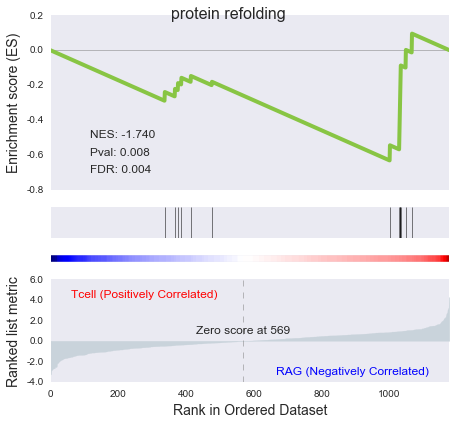

In [39]:
plot_gsea_result(bp_enr_res.loc['GO:0042026'], enr_rank)